In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [2]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
# sto_model = pyross.stochastic.SIR(parameters, M, Ni)
# data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
# data_array = data['X']
# np.save('sir_latent_traj.npy', data_array)

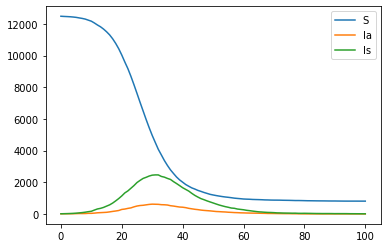

In [3]:
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='Ia')
plt.plot(data_array[:, 2*M], label='Is')
plt.legend()
plt.show()

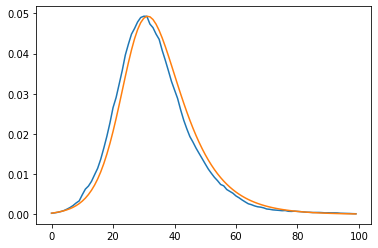

In [3]:
# load the data and rescale to intensive variables 
Tf = 100 # can truncate later 
Nf = Tf+1

x = np.load('sir_latent_traj.npy').astype('float')
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

fltr=np.repeat(np.array([False, False, True]), 2)
obs=x[:, fltr] # need to full obs for inference, don't change here 
x0=x[0]

# estimate mean and cov 
det_model = pyross.deterministic.SIR(parameters, int(M), fi)
xm,full_cov = estimator.obtain_full_mean_cov(x[0,:], Tf, Nf, det_model, contactMatrix)
plt.plot(x[1:,2*M])
plt.plot(xm[:,2*M])
plt.show()

In [4]:
# Cut the observed data 
Tf_inference = 20 
Nf_inference = Tf_inference+1 
obs = obs[:Nf_inference]

start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-284.46318626248103
0.1576838493347168


In [6]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 

alpha_g = 0.25 # better guess for alpha 
alpha_bounds = (0.15, 0.3) # better bounds on alpha 
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.07
beta_bounds = (eps, 0.1)

gIa_g = 0.145
gIa_bounds = (0.1, 0.2) # better bounds on gIa 

gIs_g = 0.145
gIs_bounds = (0.13, 0.15) 

fsa_g = 0.8

S0_g = S0/N
Ia0_g = Ia0/N

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# set up bounds for Ia and S 
bounds_for_Ia = [(0.1/N, 100/N)]*M
bounds_for_Is = [(6/N, 14/N)]*M 
bounds_for_S = [(fi[i]-100/N-Is0[i]/N, fi[i]-0.1/N) for i in range(M)]

# set up bounds for the rest of the params 
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g, *Is0])
params = estimator.latent_inference(guess, obs, fltr, Tf_inference, Nf_inference, contactMatrix, 
                                    bounds, verbose=True, niter=2, ftol=ftol, eps=eps)
# the L-BFGS-B method prints to the terminal rather than here

parameters: [0.28301839 0.02384029 0.18132023 0.14830184]
parameters: [0.28437837 0.02124761 0.1830183  0.14817532]
parameters: [0.28476727 0.02045564 0.18352826 0.14807634]
parameters: [0.28468485 0.0206034  0.18342605 0.14808306]
parameters: [0.28459385 0.02072476 0.18332486 0.14806539]
parameters: [0.28463148 0.02067281 0.18336006 0.14807125]
parameters: [0.28468787 0.02059788 0.18340226 0.14807969]
parameters: [0.28471397 0.0205715  0.18339898 0.14807926]
parameters: [0.28469232 0.0205659  0.18332506 0.14800347]
parameters: [0.28461493 0.02059355 0.18318564 0.147863  ]
parameters: [0.28452729 0.02059659 0.18304438 0.14768222]
parameters: [0.28434751 0.02059485 0.18277232 0.14739313]
parameters: [0.28434371 0.02056247 0.18274527 0.14732768]
parameters: [0.28427116 0.02054173 0.18262099 0.14713934]
parameters: [0.28426882 0.0205326  0.18262107 0.14711995]
parameters: [0.28427166 0.02053659 0.18262612 0.14707576]
parameters: [0.28426007 0.02053473 0.18260694 0.14696196]
basinhopping s

In [7]:
np.save('latent_SIR_params.npy', params)

In [5]:
params = np.load('latent_SIR_params.npy')
print('best estimates for params: ', params[:4])
print('best estimates for initial conditions: ', params[4:])

best estimates for params:  [0.1827027  0.01989663 0.15151204 0.14352511]
best estimates for initial conditions:  [2.49864457e-01 7.48552732e-01 2.56164460e-04 5.86277586e-04
 1.38550181e-04 2.10383792e-04]


In [6]:
hess_params, hess_init = estimator.hessian_latent(params, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)

In [32]:
cov_params = np.linalg.inv(hess_params)
cov_init = np.linalg.inv(hess_init)

In [36]:
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],
              'S0':params[4: 4+M],
            'Ia0':params[4+M:4+2*M],
            'Is0':params[4+2*M:],
              'fsa':fsa,
             'cov_params':cov_params,
             'cov_init':cov_init}

# Initialise pyross forecast module
model_forecast = pyross.forecast.SIR_latent(parameters, M, Ni)

In [39]:
# Number of simulations over which we average
Ns = 500 

Tf_forecast = Tf - Tf_inference
Nf_forecast = Tf_forecast+1




result_forecast = model_forecast.simulate(contactMatrix, Tf, Nf,
                                      verbose=True,
                                     Ns=Ns)

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t'] #+ Tf_inference

Finished. Time needed for evaluation: 00:00:01


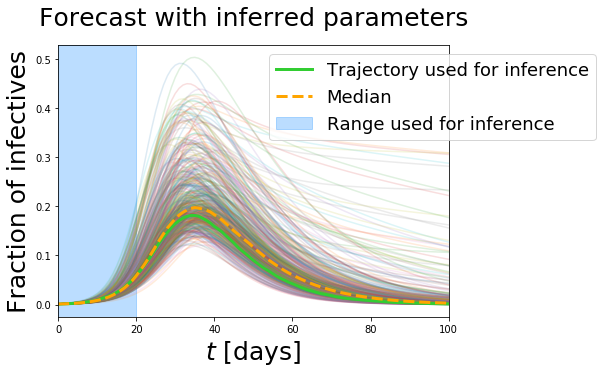

In [41]:
fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,M:3*M,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


data_array = np.load('sir_latent_traj.npy')

cur_trajectory_underlying = np.sum( data_array[:,M:3*M] ,axis=1 )
#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    #print(e)
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
''' # remove comments to plot percentiles
ax.plot(t_forecast,percentiles_lower/N,
                alpha=1,
        lw=2,
        label='Percentiles',
        ls='dotted',
        color='red',
       )
ax.plot(t_forecast,percentiles_upper/N,
                alpha=1,
        lw=2,
        color='red',
        ls='dotted',
       )
''';

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=18)
plt.show(fig)
plt.close(fig)